Есть 500 изображений лошадей для обучения.
Есть 527 изображений людей для обучения.
Есть 128 изображений лошадей для валидации.
Есть 128 изображений людей для валидации.
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
87910968/87910968 [==============================] - 3s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_752 (Conv2D)         (None, 74, 74, 32)           864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_752 (B  (None, 74, 74, 32)           96        ['c

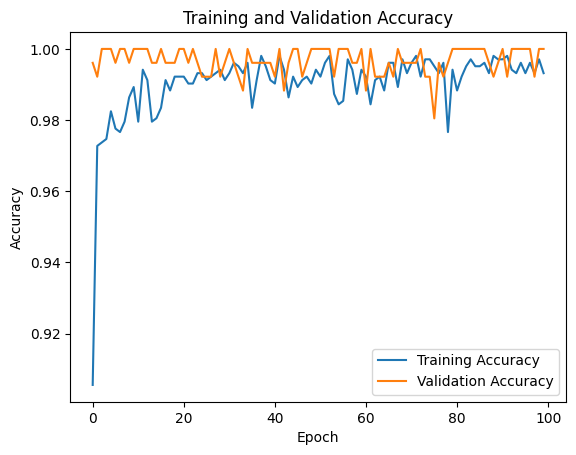

In [11]:
# Загрузка необходимых библиотек
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Загрузка данных
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

# Распаковка данных
with zipfile.ZipFile("/content/horse-or-human.zip", 'r') as zip_ref:
    zip_ref.extractall("/tmp/training")

with zipfile.ZipFile("/content/validation-horse-or-human.zip", 'r') as zip_ref:
    zip_ref.extractall("/tmp/validation")

# Определение базовых директорий для обучения и валидации
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Подсчет количества изображений в каждом классе и наборе данных
print(f"Есть {len(os.listdir(os.path.join(train_dir, 'horses')))} изображений лошадей для обучения.")
print(f"Есть {len(os.listdir(os.path.join(train_dir, 'humans')))} изображений людей для обучения.")
print(f"Есть {len(os.listdir(os.path.join(validation_dir, 'horses')))} изображений лошадей для валидации.")
print(f"Есть {len(os.listdir(os.path.join(validation_dir, 'humans')))} изображений людей для валидации.")

# Создание генераторов данных для обучения и валидации
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='binary')

# Загрузка и создание предобученной модели Inception V3
base_model = InceptionV3(input_shape=(150, 150, 3),
                         include_top=False,
                         weights='imagenet')  # Использование весов, предварительно обученных на ImageNet

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Вывод информации о модели
model.summary()

# Определение Callback для остановки обучения
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.999:
            print("\nДостигнута точность 99,9%. Прекращение обучения.")
            self.model.stop_training = True

# Обучение модели
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[MyCallback()])

# Визуализация результатов
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
